## Machine Learning Models for APS failure 

In [88]:
# Importing all the necessary libraries
import numpy as np
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,KFold
from sklearn.metrics import confusion_matrix,f1_score,log_loss,roc_curve,recall_score,precision_recall_curve,precision_score,fbeta_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
import missingno as msno
from sklearn.decomposition import PCA
from datetime import datetime
from imblearn import over_sampling
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from prettytable import PrettyTable

# 1. Machine Learning Models:

- Since the dataset is highly imbalanced, the negative class is undersampled and the positive class is upsampled, so that we have a balanced dataset.


- Following ML models are tried to get the minimum cost using Median, mean and most frequent impute
  - Logistic Regression
  - XgBoost Classifier
  - Random Forest Classifier  
    

- Error metric used is F1 score.  
Total cost = FN * 500 + FP * 10   
Where FN is also called as Type 2 error and FP is called as Type 1 error. The challenge is to find an optimal model so that the total cost is minimized. The cost can be minimized by reducing FN, therefore we can tune the ML model to have a better recall, but this could lead to increase in the number of FP. To reduce the FP we will then need to tune my models to have a better precision, but that inturn would lead to increase in FN. F1 is an overall measure of a model’s accuracy that combines precision and recall. A good F1 score means that you have low false positives and low false negatives.


# 2.1 ML models using  Median Impute

In [70]:
# Reading the train and test dataset where missing values are imputed using median
train = pd.read_csv("Train_imputed_median")
test = pd.read_csv("test_imputed_median")
y_train = pd.read_csv("y_train")
y_test = pd.read_csv("y_test")

In [71]:
train.drop(['Unnamed: 0'],axis = 1,inplace = True)
test.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_train.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_test.drop(['Unnamed: 0'],axis = 1,inplace = True)

In [72]:
train['class'] = y_train

In [73]:
#Undersampling the negative class
train_neg_sampled = train[train['class'] == 0].sample(n = 10000,random_state = 42)
train_Sampled = train[train['class'] == 1].append(train_neg_sampled)

In [74]:
print("Shape of the train data after under sampling the negative class", train_Sampled.shape[0])

Shape of the train data after under sampling the negative class 11000


In [75]:
train_Sampled.head(3)

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
9,153204.0,182.0,126.0,0.0,0.0,0.0,0.0,0.0,11804.0,684444.0,...,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0,1
23,453236.0,2926.0,126.0,0.0,0.0,0.0,0.0,222.0,323436.0,2999280.0,...,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0,1
60,72504.0,1594.0,1052.0,0.0,0.0,0.0,244.0,178226.0,1249396.0,3813464.0,...,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0,1


In [76]:
y_train = train_Sampled['class']
train_Sampled.drop(['class'],axis = 1, inplace= True)

In [77]:
# Upsampling the positive class using Smote Technique
sm = over_sampling.SMOTE(ratio= 1.0)
train_Sampled_Smote, y_train = sm.fit_sample(train_Sampled,y_train)

In [78]:
print("Shape of train data after upsampling the positive class by smote", train_Sampled_Smote.shape)

Shape of train data after upsampling the positive class by smote (20000, 160)


In [79]:
#Standardizing the data
std = StandardScaler()
train_std = std.fit_transform(train_Sampled_Smote)
test_std = std.transform(test)


# 2.1.1 Logistic Regression

In [16]:
# Defining the LR model and performing the hyper parameter tuning using gridsearch
#weights = np.linspace(0.05, 0.95, 20)
params = {'C' : [
                10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3],
          'penalty': ['l1', 'l2']#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]
         }

clf = LogisticRegression(n_jobs= -1,random_state=42)
clf.fit(train_std,y_train)
model = GridSearchCV(estimator=clf,cv = 2,n_jobs= -1,param_grid=params,scoring='f1',verbose= 2,)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  32 | elapsed:   40.2s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  1.3min finished


Best estimator is {'C': 1000, 'penalty': 'l2'}


In [50]:
# model fitting using the best parameter.
clf = LogisticRegression(n_jobs= -1,random_state=42,C= 1000,penalty= 'l2')
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15269   356]
 [   34   341]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  356
Type 2 error (False Negative) =  34
---------------------------------------------------------------------------------------------------------------------
Total cost =  20560
---------------------------------------------------------------------------------------------------------------------


- Lets try to reduce the total number of FN by adjusting the probability threshold.
- A best threshold is decided using cross validation to find the least cost. In this process we will end up finding the optimal values for FN and FP.

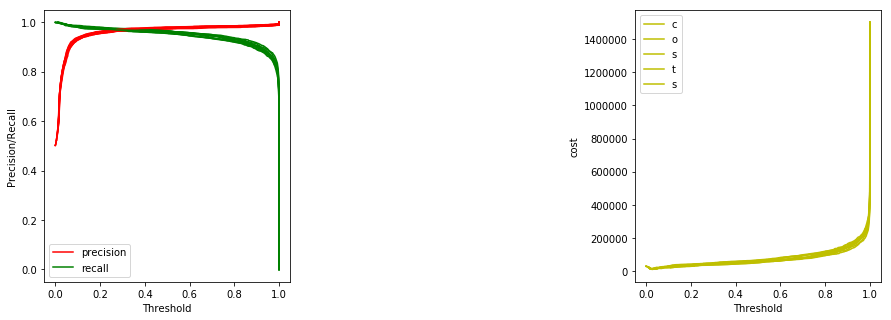

In [51]:
# Cross Validation to find the best threshold.
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    
# Plot of recall, precision v/s threshold and cost v/s threshold
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.2, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [52]:
# model fitting and finding the cost with best threshold.
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.2
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  657
Type 2 error (False Negative) =  24
---------------------------------------------------------------------------------------------------------------------
Total cost =  18570
---------------------------------------------------------------------------------------------------------------------


# 2.1.2 XgBoost

In [39]:
# model fitting and hyper parameter tuning to find the best parameter.
x_cfl=XGBClassifier()

prams={
    #'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    #'colsample_bytree':[0.1,0.3,0.5,1],
   # 'subsample':[0.1,0.3,0.5,1]
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1',cv=5)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed: 16.6min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed: 21.2min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 28.7min finished


Best estimator is {'max_depth': 10, 'n_estimators': 2000}


In [53]:
#model fitting with the best parameter.
clf = XGBClassifier(max_depth= 10,  n_estimators= 2000,n_jobs= -1)
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15446   179]
 [   34   341]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  179
Type 2 error (False Negative) =  34
---------------------------------------------------------------------------------------------------------------------
Total cost =  18790
---------------------------------------------------------------------------------------------------------------------


- Lets try to reduce the total number of FN by adjusting the probability threshold.
- A best threshold is decided using cross validation to find the least cost. In this process we will end up finding the optimal values for FN and FP.

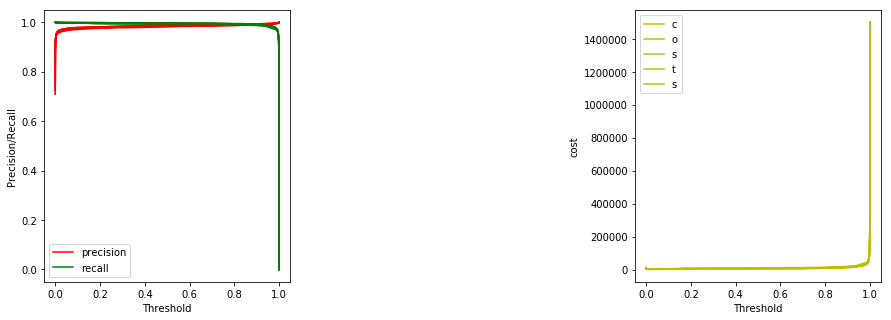

In [54]:
#Cv to find the best threshold to minimize the total cost.
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.25, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [43]:
#model fitting and predicting using the best threshold.
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.25
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  244
Type 2 error (False Negative) =  25
---------------------------------------------------------------------------------------------------------------------
Total cost =  14940
---------------------------------------------------------------------------------------------------------------------


# 2.1.3 Random Forest

In [42]:
# model fitting and hyperparamter tunning
x_cfl=RandomForestClassifier()
#weights = np.linspace(0.05, 0.95, 20)
prams={
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10]#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    
    
    
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1',cv=5)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:  4.8min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:  6.8min remaining:   41.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  7.7min finished


Best estimator is {'max_depth': 10, 'n_estimators': 1000}


In [80]:
# model fitting using the best parameter and predicting the cost
clf = RandomForestClassifier(n_estimators= 1000 , max_depth=10,n_jobs= -1)
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15204   421]
 [   14   361]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  421
Type 2 error (False Negative) =  14
---------------------------------------------------------------------------------------------------------------------
Total cost =  11210
---------------------------------------------------------------------------------------------------------------------


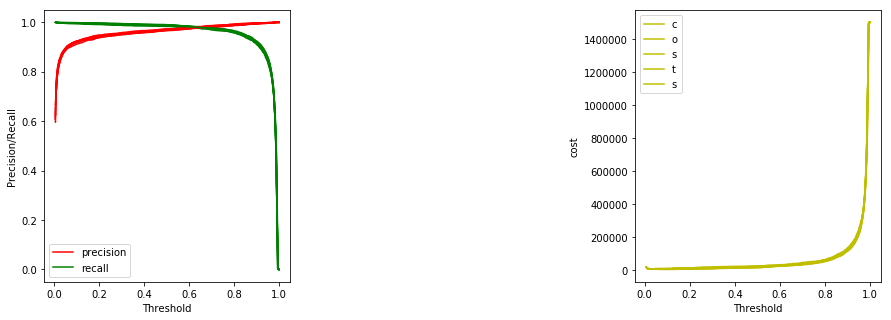

In [46]:
# CV to find the best threshold.
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.25, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [84]:
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.25
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  792
Type 2 error (False Negative) =  4
---------------------------------------------------------------------------------------------------------------------
Total cost =  9920
---------------------------------------------------------------------------------------------------------------------


# 2.2 ML models using Mean Imputation

In [2]:
# loading train and test dataset with nan values replaced with mean imputation
train = pd.read_csv("Train_imputed_mean")
test = pd.read_csv("test_imputed_mean")
y_train = pd.read_csv("y_train")
y_test = pd.read_csv("y_test")

In [3]:
train.drop(['Unnamed: 0'],axis = 1,inplace = True)
test.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_train.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_test.drop(['Unnamed: 0'],axis = 1,inplace = True)

In [4]:
train['class'] = y_train

In [5]:
# undersampling the negative class
train_neg_sampled = train[train['class'] == 0].sample(n = 10000,random_state = 42)
train_Sampled = train[train['class'] == 1].append(train_neg_sampled)

In [6]:
print("Shape of the train data after under sampling the negative class", train_Sampled.shape[0])

Shape of the train data after under sampling the negative class 11000


In [7]:
train_Sampled.head(3)

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
9,153204.0,182.0,190620.639314,0.0,0.0,0.0,0.0,0.0,11804.0,684444.0,...,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0,1
23,453236.0,2926.0,190620.639314,0.0,0.0,0.0,0.0,222.0,323436.0,2999280.0,...,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0,1
60,72504.0,1594.0,1052.000000,0.0,0.0,0.0,244.0,178226.0,1249396.0,3813464.0,...,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0,1


In [8]:
y_train = train_Sampled['class']
train_Sampled.drop(['class'],axis = 1, inplace= True)

In [9]:
# upsampling the positive class using smote to have balanced dataset.
sm = over_sampling.SMOTE(ratio= 1.0)
train_Sampled_Smote, y_train = sm.fit_sample(train_Sampled,y_train)

In [10]:
print("Shape of train data after upsampling the positive class by smote", train_Sampled_Smote.shape)

Shape of train data after upsampling the positive class by smote (20000, 160)


In [11]:
# Standardizing the train and test data.
std = StandardScaler()
train_std = std.fit_transform(train_Sampled_Smote)
test_std = std.transform(test)


# 2.2.1 Logistic Regression

In [13]:
# model fitting and hyper parameter tuning using gridsearch
#weights = np.linspace(0.05, 0.95, 20)
params = {'C' : [
                10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3],
          'penalty': ['l1', 'l2']#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]
         }

clf = LogisticRegression(n_jobs= -1,random_state=42)
clf.fit(train_std,y_train)
model = GridSearchCV(estimator=clf,cv = 2,n_jobs= -1,param_grid=params,scoring='f1',verbose= 2,)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  32 | elapsed:   28.7s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   37.6s finished


Best estimator is {'C': 1000, 'penalty': 'l2'}


In [14]:
#model fitting using the best parameter.
clf = LogisticRegression(n_jobs= -1,random_state=42,C= 1000,penalty= 'l2')
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15257   368]
 [   40   335]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  368
Type 2 error (False Negative) =  40
---------------------------------------------------------------------------------------------------------------------
Total cost =  23680
---------------------------------------------------------------------------------------------------------------------


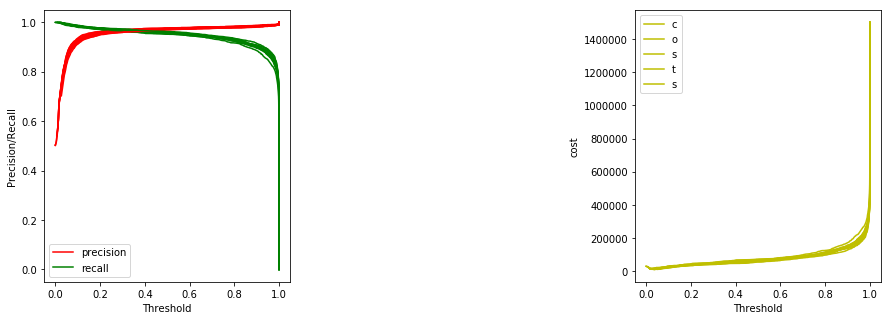

In [15]:
# CV for determining the best threshold
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.2, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [16]:
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.20
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  730
Type 2 error (False Negative) =  25
---------------------------------------------------------------------------------------------------------------------
Total cost =  19800
---------------------------------------------------------------------------------------------------------------------


# 2.2.2 XgBoost

In [21]:

x_cfl=XGBClassifier(n_jobs = -1)
prams={
    'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1',cv=5)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed: 16.9min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed: 22.4min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 29.5min finished


Best estimator is {'max_depth': 5, 'n_estimators': 500}


In [22]:
clf = XGBClassifier(max_depth= 5,n_estimators= 500,n_jobs= -1)
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15449   176]
 [   35   340]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  176
Type 2 error (False Negative) =  35
---------------------------------------------------------------------------------------------------------------------
Total cost =  19260
---------------------------------------------------------------------------------------------------------------------


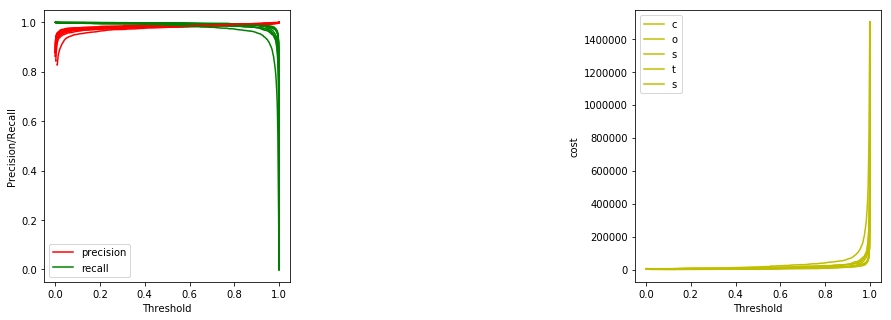

In [23]:
# CV to determine the best threshold
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.2, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [24]:
# model fitting and prediction using the best threshold
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.20
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  257
Type 2 error (False Negative) =  26
---------------------------------------------------------------------------------------------------------------------
Total cost =  15570
---------------------------------------------------------------------------------------------------------------------


# 2.2.3  Random Forest

In [26]:
#model fitting and hyper parameter tuning to find the best parameters
x_cfl=RandomForestClassifier()
#weights = np.linspace(0.05, 0.95, 20)
prams={
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10]#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    
    
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1',cv=5)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:  4.8min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:  6.7min remaining:   41.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  7.7min finished


Best estimator is {'max_depth': 10, 'n_estimators': 2000}


In [27]:
#model fitting using best parameter
clf = RandomForestClassifier(n_estimators= 2000 , max_depth=10,n_jobs= -1)
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15207   418]
 [   15   360]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  418
Type 2 error (False Negative) =  15
---------------------------------------------------------------------------------------------------------------------
Total cost =  11680
---------------------------------------------------------------------------------------------------------------------


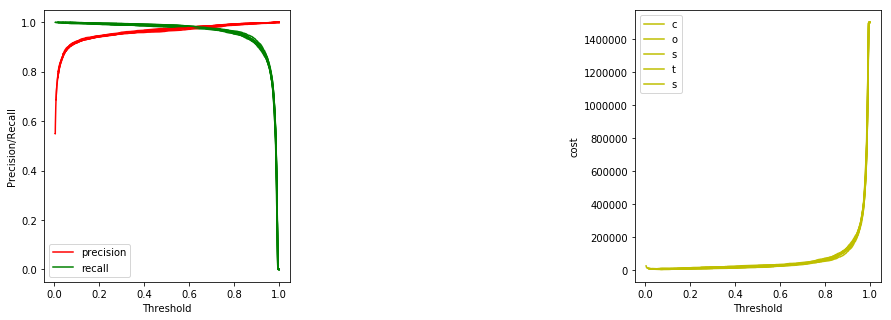

In [28]:
#CV to determine the best threshold
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.25, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [31]:
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.25
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  767
Type 2 error (False Negative) =  6
---------------------------------------------------------------------------------------------------------------------
Total cost =  10670
---------------------------------------------------------------------------------------------------------------------


# 2.3 ML models using Most Frequent Impute

In [2]:
#loading the train and test dataset
train = pd.read_csv("Train_imputed_most_frequent")
test = pd.read_csv("test_imputed_most_frequent")
y_train = pd.read_csv("y_train")
y_test = pd.read_csv("y_test")

In [3]:
train.drop(['Unnamed: 0'],axis = 1,inplace = True)
test.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_train.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_test.drop(['Unnamed: 0'],axis = 1,inplace = True)

In [4]:
train['class'] = y_train

In [5]:
#undersampling the negative class
train_neg_sampled = train[train['class'] == 0].sample(n = 10000,random_state = 42)
train_Sampled = train[train['class'] == 1].append(train_neg_sampled)

In [6]:
print("Shape of the train data after under sampling the negative class", train_Sampled.shape[0])

Shape of the train data after under sampling the negative class 11000


In [7]:
train_Sampled.head(3)

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
9,153204,182,0,0,0,0,0,0,11804,684444,...,26872,34044,22472,34362,0,0,0,0,0,1
23,453236,2926,0,0,0,0,0,222,323436,2999280,...,3026002,5025350,2025766,1160638,533834,493800,6914,0,0,1
60,72504,1594,1052,0,0,0,244,178226,1249396,3813464,...,372252,527514,358274,332818,284178,3742,0,0,0,1


In [8]:
y_train = train_Sampled['class']
train_Sampled.drop(['class'],axis = 1, inplace= True)

In [9]:
#Upsampling the positive class using smote technique to have a balanced dataset.
sm = over_sampling.SMOTE(ratio= 1.0)
train_Sampled_Smote, y_train = sm.fit_sample(train_Sampled,y_train)

In [10]:
print("Shape of train data after upsampling the positive class by smote", train_Sampled_Smote.shape)

Shape of train data after upsampling the positive class by smote (20000, 160)


In [11]:
#Standardizing the train and test data.
std = StandardScaler()
train_std = std.fit_transform(train_Sampled_Smote)
test_std = std.transform(test)


# 2.3.1 Logistic Regression

In [12]:
# model fitting and hyper parameter tuning using gridsearch
#weights = np.linspace(0.05, 0.95, 20)
params = {'C' : [
                10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3],
          'penalty': ['l1', 'l2']#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]
         }

clf = LogisticRegression(n_jobs= -1,random_state=42)
clf.fit(train_std,y_train)
model = GridSearchCV(estimator=clf,cv = 2,n_jobs= -1,param_grid=params,scoring='f1',verbose= 2,)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  32 | elapsed:   41.1s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   58.4s finished


Best estimator is {'C': 1000, 'penalty': 'l2'}


In [13]:
# model fitting using best parameter
clf = LogisticRegression(n_jobs= -1,random_state=42,C= 1000,penalty= 'l2')
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15274   351]
 [   35   340]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  351
Type 2 error (False Negative) =  35
---------------------------------------------------------------------------------------------------------------------
Total cost =  21010
---------------------------------------------------------------------------------------------------------------------


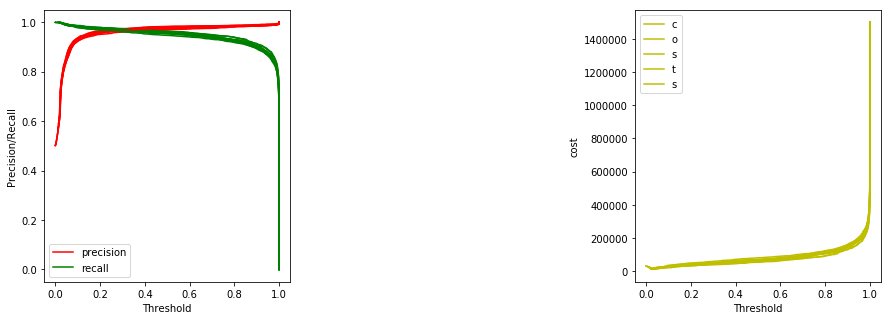

In [14]:
#CV for determining the best threshold
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.2, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [15]:
# model fitting and prediciting using the best threshold
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.20
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  665
Type 2 error (False Negative) =  21
---------------------------------------------------------------------------------------------------------------------
Total cost =  17150
---------------------------------------------------------------------------------------------------------------------


# 2.3.2 XgBoost

In [16]:
# model fitting and hyperparameter tunning using gridsearch
x_cfl=XGBClassifier()

prams={
    
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10]
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1',cv=5)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed: 19.0min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed: 24.2min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 32.6min finished


Best estimator is {'max_depth': 10, 'n_estimators': 1000}


In [17]:
# model fitting using the best parameter
clf = XGBClassifier(max_depth= 10, n_estimators= 1000,n_jobs= -1)
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15389   236]
 [   33   342]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  236
Type 2 error (False Negative) =  33
---------------------------------------------------------------------------------------------------------------------
Total cost =  18860
---------------------------------------------------------------------------------------------------------------------


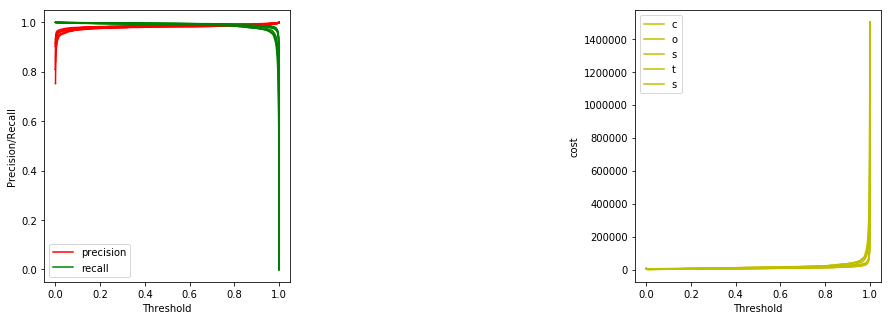

In [18]:
#CV to determine the best threshold
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.25, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [19]:
# model fitting and predicting using the best threshold
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.25
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  331
Type 2 error (False Negative) =  24
---------------------------------------------------------------------------------------------------------------------
Total cost =  15310
---------------------------------------------------------------------------------------------------------------------


# 2.3.3 Random Forest

In [20]:
# model fitting and hyperparameter tunning using gridsearch
x_cfl=RandomForestClassifier()
#weights = np.linspace(0.05, 0.95, 20)
prams={
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10]#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    
    
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1',cv=5)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:  5.2min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:  7.0min remaining:   43.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  8.0min finished


Best estimator is {'max_depth': 10, 'n_estimators': 1000}


In [21]:
# model fitting using the best parameter
clf = RandomForestClassifier(n_estimators= 1000 , max_depth=10,n_jobs= -1)
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15192   433]
 [   12   363]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  433
Type 2 error (False Negative) =  12
---------------------------------------------------------------------------------------------------------------------
Total cost =  10330
---------------------------------------------------------------------------------------------------------------------


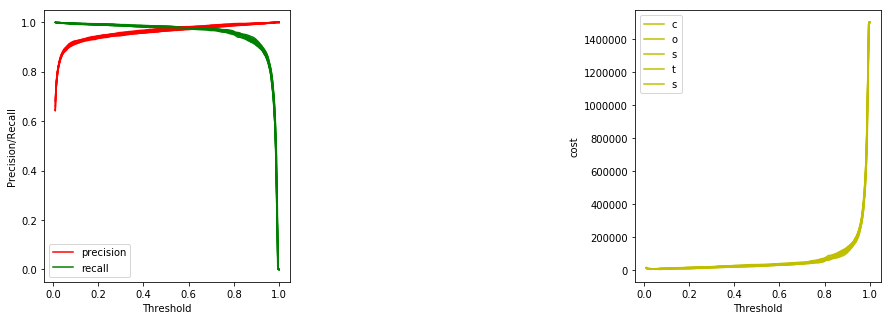

In [22]:
#CV for determining the best threshold
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.2, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [26]:
#model fitting and predicting using the best threshold
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.20
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  881
Type 2 error (False Negative) =  3
---------------------------------------------------------------------------------------------------------------------
Total cost =  10310
---------------------------------------------------------------------------------------------------------------------


# Let us try doing some kind of Feature Engineering to reduce the total cost.

# 3. Feature Engineering

- From the above ML models on three different Imputation techniques, Random Forest with median imputation provides the least cost. Therefore we will perform feature engineering on train and test data with median imputation. We will also use Random Forest model, since it gave the best performance.

- For FE, we will use median imputation to fill the missing data and we will create new features called missing indicator, which creates new features where missing values are indicated as True and non missing values as False.

In [2]:
# loading the train and test dataset with missing indicator features.
train = pd.read_csv("Train_imputed_median")
test = pd.read_csv("test_imputed_median")
train_miss = pd.read_csv("train_miss_indi.csv")
test_miss = pd.read_csv("test_miss_indi.csv")
y_train = pd.read_csv("y_train")
y_test = pd.read_csv("y_test")

In [3]:
train.drop(['Unnamed: 0'],axis = 1,inplace = True)
test.drop(['Unnamed: 0'],axis = 1,inplace = True)
train_miss.drop(['Unnamed: 0'],axis = 1,inplace = True)
test_miss.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_train.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_test.drop(['Unnamed: 0'],axis = 1,inplace = True)

In [4]:
train['class'] = y_train

In [5]:
train[train_miss.columns] = train_miss
test[test_miss.columns] = test_miss


In [6]:
# Downsampling the negative class
train_neg_sampled = train[train['class'] == 0].sample(n = 10000,random_state = 42)
train_Sampled = train[train['class'] == 1].append(train_neg_sampled)

In [7]:
print("Shape of the train data after under sampling the negative class", train_Sampled.shape[0])

Shape of the train data after under sampling the negative class 11000


In [8]:
train_Sampled.head(3)

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,149,150,151,152,153,154,155,156,157,158
9,153204.0,182.0,126.0,0.0,0.0,0.0,0.0,0.0,11804.0,684444.0,...,False,False,False,False,False,False,False,False,False,False
23,453236.0,2926.0,126.0,0.0,0.0,0.0,0.0,222.0,323436.0,2999280.0,...,False,False,False,False,False,False,False,False,False,False
60,72504.0,1594.0,1052.0,0.0,0.0,0.0,244.0,178226.0,1249396.0,3813464.0,...,False,False,False,False,False,False,False,False,False,False


- columns from 0 to 158 are the missing indicator features. Where False is basically indicating the non missing values and true indicates the missing values. missing values can also be treated as features.

In [9]:
y_train = train_Sampled['class']
train_Sampled.drop(['class'],axis = 1, inplace= True)

In [10]:
#Upsampling the positive class
sm = over_sampling.SMOTE(ratio= 1.0)
train_Sampled_Smote, y_train = sm.fit_sample(train_Sampled,y_train)

In [11]:
print("Shape of train data after upsampling the positive class by smote", train_Sampled_Smote.shape)

Shape of train data after upsampling the positive class by smote (20000, 319)


In [12]:
# Standardizing the train and test data
std = StandardScaler()
train_std = std.fit_transform(train_Sampled_Smote)
test_std = std.transform(test)


# 3.1 Random Forest

In [18]:
# model fitting and hyperparameter tuning using gridsearch
x_cfl=RandomForestClassifier()
#weights = np.linspace(0.05, 0.95, 20)
prams={
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10]#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    
    
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1',cv=5)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:  5.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:  7.6min remaining:   46.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  8.3min finished


Best estimator is {'max_depth': 10, 'n_estimators': 100}


In [19]:
# model fitting with best parameters
clf = RandomForestClassifier(n_estimators= 100 , max_depth=10)
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15199   426]
 [   16   359]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  426
Type 2 error (False Negative) =  16
---------------------------------------------------------------------------------------------------------------------
Total cost =  12260
---------------------------------------------------------------------------------------------------------------------


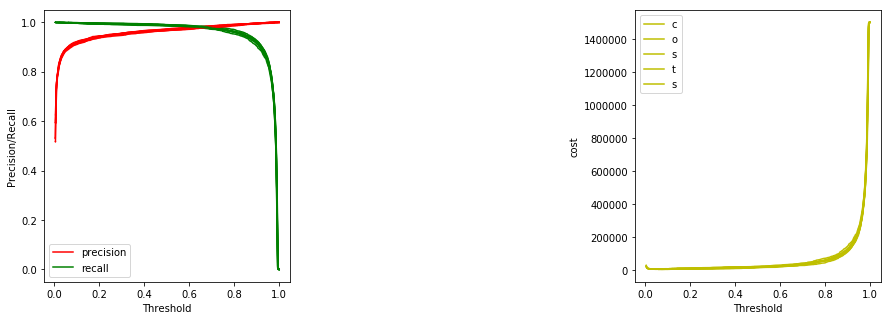

In [20]:
# CV to determine the best threshold
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.2, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [22]:
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.20
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  892
Type 2 error (False Negative) =  3
---------------------------------------------------------------------------------------------------------------------
Total cost =  10420
---------------------------------------------------------------------------------------------------------------------


# 4. Lets Try Dimensionality Reduction to minimize the cost

# Dimensionality Reduction

- We will use PCA to perform dimensionality reduction.

In [34]:
train = pd.read_csv("Train_imputed_median")
test = pd.read_csv("test_imputed_median")
y_train = pd.read_csv("y_train")
y_test = pd.read_csv("y_test")

train.drop(['Unnamed: 0'],axis = 1,inplace = True)
test.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_train.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_test.drop(['Unnamed: 0'],axis = 1,inplace = True)

#train['class'] = y_train

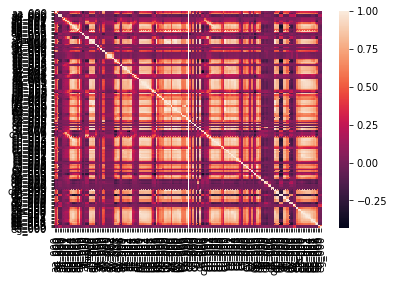

In [35]:
# Determining the correlation between features using spearman correlation and plotting the heatmap.
corelation_matrix = train.corr(method='spearman')

sns.heatmap(data = corelation_matrix,xticklabels=train.columns,yticklabels=train.columns)


In [36]:
#Performing standardization and PCA for dimensionality reduction
start = datetime.now()
std = StandardScaler()
train_std = std.fit_transform(train)
train_pca = PCA(n_components= 160,random_state=42)
train_pca.fit_transform(train_std)
print("Time required to run this cell", datetime.now() - start)

Time required to run this cell 0:00:01.586515


<function matplotlib.pyplot.show(*args, **kw)>

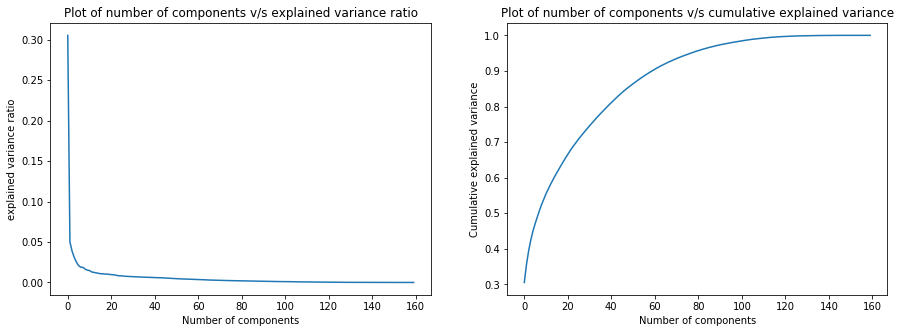

In [37]:
# Plot of number of features v/s explained variance ratio.
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data=train_pca.explained_variance_ratio_)
plt.xlabel("Number of components")
plt.ylabel("explained variance ratio")
plt.title("Plot of number of components v/s explained variance ratio")
plt.subplot(1,2,2)
sns.lineplot(data=np.cumsum(train_pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Plot of number of components v/s cumulative explained variance")
plt.show

In [86]:
print("With Number of components as 90, the total explained variance is " ,train_pca.explained_variance_ratio_[:90].sum())

With Number of components as 90, the total explained variance is  0.9720430145910608


- With 90 features we have a explained variance of 97%. Therefore we have reduced the dimension from 160 features to 90 features.

In [39]:
pca_100 = PCA(n_components=90,random_state=42)
train_100= pca_100.fit_transform(train_std)


In [40]:
test_std = std.transform(test)
test_100 = pca_100.transform(test_std)

In [50]:
train = pd.DataFrame(train_100)
test = pd.DataFrame(test_100)
train['class'] = y_train

In [51]:
#downsampling the negative class
train_neg_sampled = train[train['class'] == 0].sample(n = 10000,random_state = 42)
train_Sampled = train[train['class'] == 1].append(train_neg_sampled)

In [52]:
print("Shape of the train data after under sampling the negative class", train_Sampled.shape[0])

Shape of the train data after under sampling the negative class 11000


In [53]:
train_Sampled.head(3)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,class
9,0.190852,0.905957,0.520404,0.136505,-3.068258,-1.287986,0.026602,0.439500,-0.393549,-3.048622,...,-0.270087,0.557541,-0.401641,-1.067877,0.656409,-0.734957,0.021046,0.108050,-0.706376,1
23,25.150199,-4.778222,8.575955,-6.548307,3.579923,2.978047,0.014882,13.988875,-1.397697,2.688728,...,2.530381,1.641916,4.162028,-1.481875,0.698249,2.955495,3.221251,2.397192,-0.401677,1
60,3.754447,2.756846,-0.759256,2.103532,1.117280,-0.735061,-0.010214,1.381170,-0.655980,0.990501,...,0.097937,0.716064,0.535049,-0.481472,0.326055,-1.499467,-0.664483,-0.684844,-0.339594,1


In [54]:
y_train = train_Sampled['class']
train_Sampled.drop(['class'],axis = 1, inplace= True)

In [55]:
# Upsampling the positive class to have a balanced dataset.
sm = over_sampling.SMOTE(ratio= 1.0)
train_Sampled_Smote, y_train = sm.fit_sample(train_Sampled,y_train)

In [56]:
print("Shape of train data after upsampling the positive class by smote", train_Sampled_Smote.shape)

Shape of train data after upsampling the positive class by smote (20000, 90)


In [57]:
std = StandardScaler()
train_std = std.fit_transform(train_Sampled_Smote)
test_std = std.transform(test)


# 4.1 Random Forest

In [58]:
# model fitting and hyperparameter tuning using gridsearch
x_cfl=RandomForestClassifier()
#weights = np.linspace(0.05, 0.95, 20)
prams={
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10]#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    
    
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1',cv=5)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:  9.9min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed: 13.5min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 15.7min finished


Best estimator is {'max_depth': 10, 'n_estimators': 500}


In [59]:
# model fitting using the best parameter
clf = RandomForestClassifier(n_estimators= 500 , max_depth=10)
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15065   560]
 [   11   364]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  560
Type 2 error (False Negative) =  11
---------------------------------------------------------------------------------------------------------------------
Total cost =  11100
---------------------------------------------------------------------------------------------------------------------


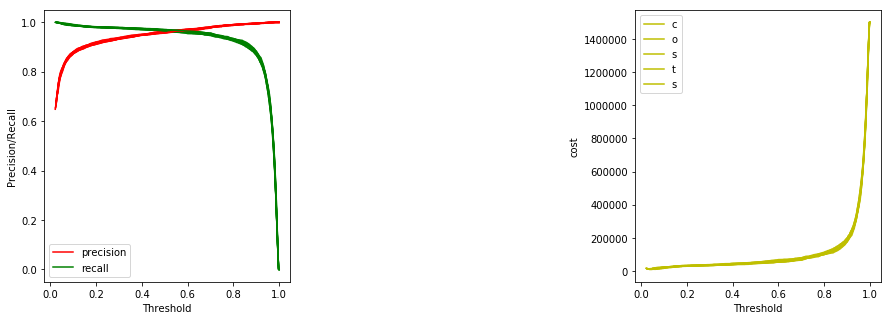

In [60]:
#CV to determine the best threshold
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.3, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [62]:
# model fitting and predicting using the best threshold
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.30
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  998
Type 2 error (False Negative) =  3
---------------------------------------------------------------------------------------------------------------------
Total cost =  11480
---------------------------------------------------------------------------------------------------------------------


# Results:

In [91]:
table1 = PrettyTable()
print("Table showing the total cost for different models with median Imputation")
table1.field_names = (['Model', 'FN', 'FP', 'Total Cost'])
table1.add_row(['LR', 24,657,18570])
table1.add_row(['XgBoost', 25,244,14940])
table1.add_row(['Random Forest', 4,792,9920])
print(table1)

print('='*117)
table2 = PrettyTable()
print("Table showing the total cost for different models with mean Imputation")
table2.field_names = (['Model', 'FN', 'FP', 'Total Cost'])
table2.add_row(['LR', 25,730,19800])
table2.add_row(['XgBoost', 26,257,15570])
table2.add_row(['Random Forest', 6,767,10670])
print(table2)

print('='*117)

table3 = PrettyTable()
print("Table showing the total cost for different models with most frequent Imputation")
table3.field_names = (['Model', 'FN', 'FP', 'Total Cost'])
table3.add_row(['LR', 21,665,17150])
table3.add_row(['XgBoost', 24,331,15310])
table3.add_row(['Random Forest', 3,881,10310])
print(table3)

print('='*117)

table4 = PrettyTable()
print("Table showing the total cost for Random Forest model with feature engineered features and median Imputation")
table4.field_names = (['Model', 'FN', 'FP', 'Total Cost'])
table4.add_row(['Random Forest', 3,892,10420])
print(table4)
print('='*117)

table5 = PrettyTable()
print("Table showing the total cost for Random Forest model with reduced dimensions and median Imputation")
table5.field_names = (['Model', 'FN', 'FP', 'Total Cost'])
table5.add_row(['Random Forest', 3,998,11480])
print(table5)
print('='*117)

Table showing the total cost for different models with median Imputation
+---------------+----+-----+------------+
|     Model     | FN |  FP | Total Cost |
+---------------+----+-----+------------+
|       LR      | 24 | 657 |   18570    |
|    XgBoost    | 25 | 244 |   14940    |
| Random Forest | 4  | 792 |    9920    |
+---------------+----+-----+------------+
Table showing the total cost for different models with mean Imputation
+---------------+----+-----+------------+
|     Model     | FN |  FP | Total Cost |
+---------------+----+-----+------------+
|       LR      | 25 | 730 |   19800    |
|    XgBoost    | 26 | 257 |   15570    |
| Random Forest | 6  | 767 |   10670    |
+---------------+----+-----+------------+
Table showing the total cost for different models with most frequent Imputation
+---------------+----+-----+------------+
|     Model     | FN |  FP | Total Cost |
+---------------+----+-----+------------+
|       LR      | 21 | 665 |   17150    |
|    XgBoost    | 24

# Conclusion:

- Random Forest model provides the least cost for all the three imputation techniques. For binary classifiers, the threshold is by default set to 0.5.  By adjusting the threshold towards the lower end, its possible to reduce the FN at the cost of increase in FP. Since the total cost is equal to 500 x FN and 100 x FP, to have a minimal cost it is required to have a lower FN. 
- This is achieved by having a proper precision recall tradeoff.

# Procedure:
 
- First we read the train and test dataset. Through EDA it was observed that both train and test datasets where highly imbalanced dataset.
- Since the given dataset had large number of missing values, various imputation techniques were applied to replace the missing values in the dataset. Also all the columns where the missing values were more than 70%, such columns were dropped from the dataset.
- Imputation techniques like median, mean and most frequent were used.
- After performing imputation, the train and test dataset were saved as csv files for further processing.
- Next we applied Different ML models to the imputed datasets.
- Since the given data was highly an imbalanced dataset, in the train data negative class was downsmapled and positive class was upsampled using the smote technique.
- Different ML models were trained and fine tuned to find the best parameter for each of the imputation techniques.
- Once the best parameters were found, next we trained the models using the best parameters and the total cost was predicted. Since the cost of making a FN is 5 times more than making FP, the trained models were further tune with respect to probability threshold, so that we can somehow have a model which is more baised towards positive class, thus reducing the FN and finally the total cost.
- WE also did some Feature engineering and found new features. This new features were the missing value indicators. Since median imputation performed well with Random forest, these new features were combined with median imputation and a random forest model was tuned to find the best parameter using gridsearchcv. 
- We also tried reducing the dimension of the trained dataset to improved the total cost. Here PCA was used for dimensionality reduction. After performing PCA, it was found that 90 features explained more than 97% of the variance in the data. Again it was performed using median imputation and model used was Random Forest.
- Results of all the models are present in the table above.

# END